In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import functools
import community

from scipy import sparse
from scipy.sparse import linalg
import time
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from math import sqrt
import pandas as pd
from shapely.ops import cascaded_union
pd.set_option('precision', 10)

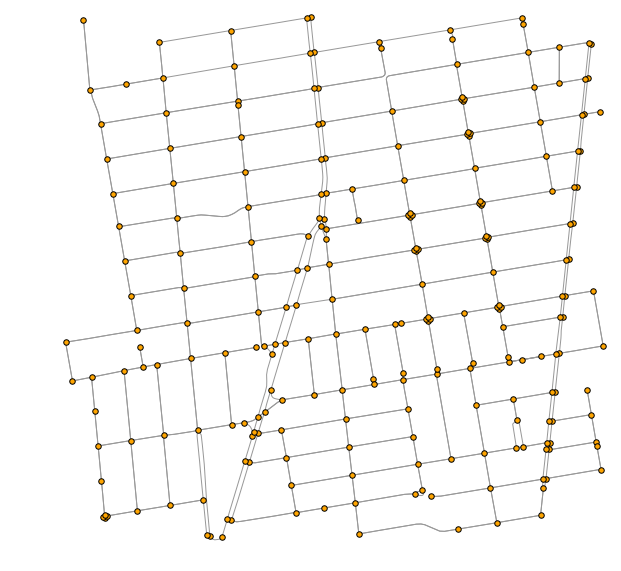

In [431]:
address = '2700 Shattuck Ave, Berkeley, CA'
f = ox.graph_from_address(address, network_type='drive', distance=750, simplify = True)
f = ox.project_graph(f)
fig, ax = ox.plot_graph(f, fig_height=10, node_color='orange', node_size=30, 
                        node_zorder=2, node_edgecolor='k')

In [432]:
nodes = ox.graph_to_gdfs(f, edges=False)
buffered_nodes = nodes.buffer(15).unary_union
if isinstance(buffered_nodes, Polygon): buffered_nodes = [buffered_nodes]

In [433]:
buffered_nodes_geoS = gpd.GeoSeries(list(buffered_nodes))
buffered_nodes_df =  pd.concat([buffered_nodes_geoS.rename('geometry'), 
                                 pd.Series(buffered_nodes_geoS.index).rename('code')], axis=1)

buffered_nodes_gdf = gpd.GeoDataFrame(buffered_nodes_df , geometry = buffered_nodes_df.geometry)

In [434]:
buffered_nodes_gdf['area']= buffered_nodes_gdf['geometry'].area
buffered_nodes_gdf['centroid'] = buffered_nodes_gdf.geometry.centroid

In [435]:
nodes['cluster'] ='NA'

for row in nodes.itertuples():
    for row_bn in buffered_nodes_gdf.itertuples():
        if (row_bn[buffered_nodes_gdf.columns.get_loc("area")+1] < 706): continue
        elif row[nodes.columns.get_loc("geometry")+1].within(row_bn[buffered_nodes_gdf.columns.get_loc("geometry")+1]): 
            nodes.set_value(row[0], 'cluster', row_bn[buffered_nodes_gdf.columns.get_loc("code")+1])

In [436]:
merged = buffered_nodes_gdf[buffered_nodes_gdf["area"] > 706]

for row in merged.itertuples():
    
    x, y = row[merged.columns.get_loc("centroid")+1].coords.xy
    merged.set_value(row[0],'x', x[0])
    merged.set_value(row[0], 'y', y[0])

C:\Users\g_filo01\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\g_filo01\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [437]:
edges = ox.graph_to_gdfs(f, nodes = False)
edges = edges.rename(columns = {'u':'old_u'})
edges = edges.rename(columns = {'v':'old_v'})

In [438]:
for row in edges.itertuples():
    
    index_old_u = edges.columns.get_loc("old_u")+1
    index_old_v = edges.columns.get_loc("old_v")+1   
    index_geometry = edges.columns.get_loc("geometry")+1   
    
    line_list = list(row[index_geometry].coords)
        
    u = nodes.loc[row[index_old_u]]["cluster"]
    v = nodes.loc[row[index_old_v]]["cluster"]
   
    if ((u != 'NA') & (v !='NA')):
            line_list[-1] = (merged.loc[v]['x'], merged.loc[v]['y'])
            line_list[0] = (merged.loc[u]['x'], merged.loc[u]['y'])
    elif ((u == 'NA') & (v =='NA')):
            u = row[index_old_u]
            v = row[index_old_v]
    elif (u == 'NA'): 
            u = row[index_old_u]
            line_list[-1] = (merged.loc[v]['x'], merged.loc[v]['y'])
    elif (v == 'NA'): 
            v = row[index_old_v]
            line_list[0] = (merged.loc[u]['x'], merged.loc[u]['y'])
        
    lineGeo = (LineString([coor for coor in line_list])).simplify(1, preserve_topology =True)   
        
    edges.set_value(row[0],"u", u)
    edges.set_value(row[0],"v", v)
    edges.set_value(row[0],"geometry", lineGeo)

In [ ]:


for row in edges.itertuples():
    if (row[0] is in dropped :continue 
    index_key = edges.columns.get_loc("key")+1
    index_type = edges.columns.get_loc("highway")+1
    index_u = edges.columns.get_loc("u")+1
    index_v = edges.columns.get_loc("v")+1
    index_geometry = edges.columns.get_loc("geometry")+1
    
    for rowC in edges.itertuples():
        if row[0] == rowC[0]: continue
        if ((row[index_u] != rowC[index_u] & row[index_u] != rowC[index_v]) | 
            (row[index_u] != rowC[index_v] & row[index_v] != rowC[index_u])): continue
        if row[index_key] != rowC[index_key]: continue
        if ((row[index_type] == 'motorway') != (row[index_type] == 'motorway'): continue
        
        else:
            lineGeometry_A = list(row[index_geometry].coords)
            lineGeometry_B = list(rowC[index_geometry].coords)
            
            if len (lineGeometry_A) == len(lineGeometry_B):
                to_drop = True
                new_line = lineGeometry_A
                for n, i in enumerate(lineGeometry_A):
                    if (n == 0): continue
                    elif (n == len(lineGeometry_A)-1): continue
                    else:
                        AB = LineString([coor for coor in [lineGeometry_A[n], lineGeometry_B[n]]])
                        new_point = AB.centroid            
                        new_line[n] = new_point
                
        lineGeo = LineString([coor for coor in [lineS[0], lineS[1]]])
        edges.set_value(row[0],'geometry', lineGeo)
        edges.set_value(row[0],'oneway', False)   
        if (to_drop == True): 
            edges.drop([rowC[0]])
            dropped.append(rowC[0])

            

In [439]:
for row in merged.itertuples():
    index_x = merged.columns.get_loc("x")+1
    index_y = merged.columns.get_loc("y")+1

    index_centroid = merged.columns.get_loc("centroid")+1
    nodes_new.loc[row[0]] = ["NaN", "NaN", "NaN", "NaN", row[index_x],row[index_y], row[index_centroid],'NA']

In [440]:
nodes_new = nodes_new[nodes_new['cluster'] == "NA"]
nodes_new['osmid'] = nodes_new.index.astype(int)
nodes_new['x'] = nodes_new['x'].astype(float)
nodes_new['y'] = nodes_new['y'].astype(float)
nodes_new.gdf_name = 'new_nodes'

In [441]:
G = ox.gdfs_to_graph(nodes_new, edges)

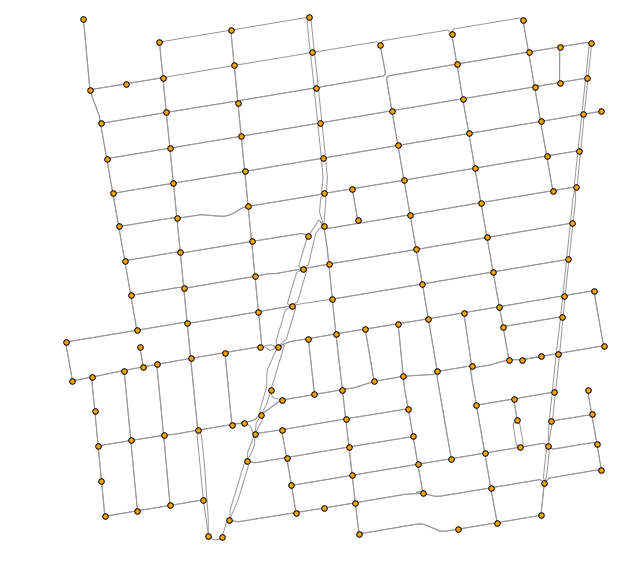

In [442]:
# G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=10, node_color='orange', node_size=30, 
                        node_zorder=2, node_edgecolor='k')

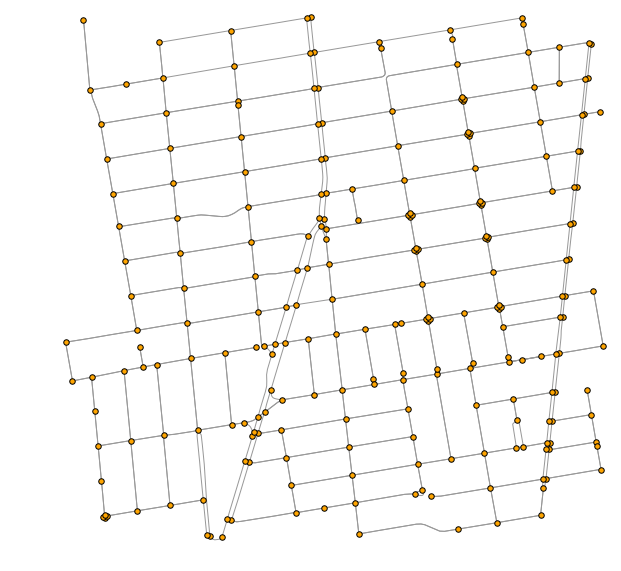

In [277]:
address = '2700 Shattuck Ave, Berkeley, CA'
f = ox.graph_from_address(address, network_type='drive', distance=750)
f = ox.project_graph(f)
fig, ax = ox.plot_graph(f, fig_height=10, node_color='orange', node_size=30, 
                        node_zorder=2, node_edgecolor='k')

In [185]:
for row in nodes.:
    if (i not in list(nodes_fil.index)): continue
    else:
        cluster = nodes_fil.loc[i]['cluster']
        modify[i] = cluster

In [157]:
for i in G.edges():
    print(G[i[0]][i[1]])

{0: {'osmid': 22372749, 'name': 'Dwight Way', 'highway': 'tertiary', 'maxspeed': '25 mph', 'oneway': False, 'length': 99.418365546772861, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000025A88764DD8>}}
{0: {'osmid': 26379345, 'name': 'Grant Street', 'highway': 'residential', 'maxspeed': '25 mph', 'oneway': False, 'length': 100.90966234441541, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000025A88764DA0>}}
{0: {'osmid': 26379345, 'name': 'Grant Street', 'highway': 'residential', 'maxspeed': '25 mph', 'oneway': False, 'length': 202.63978598714942, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000025A88764AC8>}}
{0: {'osmid': 22372749, 'name': 'Dwight Way', 'highway': 'tertiary', 'maxspeed': '25 mph', 'oneway': False, 'length': 104.62479995419169, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000025A88764D30>}}
{0: {'osmid': 22372749, 'name': 'Dwight Way', 'highway': 'tertiary', 'maxspeed': '25 mph', 'oneway': F

In [39]:
G = ox.gdfs_to_graph(nodes, edges)
    t = G.nodes()
    pos = {}

    for l, item in enumerate(t): pos[item] = (t[l]['x'],t[l]['y'], t[item]['nodeID'])

    Ng = nx.Graph() #Empty graph
    Ng = Ng.to_undirected()
    Ng.add_nodes_from(pos.keys()) #Add nodes preserving coordinates

    for i, item in enumerate(Ng.nodes()):
        Ng.node[item]['x']=pos[item][0]
        Ng.node[item]['y']=pos[item][1]
        Ng.node[item]['nodeID']=pos[item][2]

    for i, item in enumerate(G.edges()):
        Ng.add_edge(item[0], item[1])
        Ng[item[0]][item[1]]['length']=G[item[0]][item[1]][0]['length']
        Ng[item[0]][item[1]]['streetID']=G[item[0]][item[1]][0]['streetID']

0       978.3286614526
1       705.7234103712
2       705.7234103712
3       705.7234103712
4       705.7234103712
5      1051.0807942793
6       705.7234103712
7       705.7234103712
8      1597.7516599473
9       705.7234103712
10     2015.6090307559
11      705.7234103712
12      705.7234103712
13     1156.7040296244
14      705.7234103712
15      705.7234103712
16      705.7234103712
17      705.7234103712
18      705.7234103712
19      705.7234103712
20      705.7234103712
21      705.7234103712
22     1075.3509488184
23      705.7234103712
24      705.7234103712
25      705.7234103712
26      705.7234103712
27     1574.9214933777
28      705.7234103712
29     1248.7463545033
            ...       
128     905.3361377536
129     705.7234103712
130     705.7234103712
131     705.7234103712
132     705.7234103712
133    1193.2775414594
134    1042.4725909049
135     705.7234103712
136    1035.5115234009
137     705.7234103712
138     705.7234103712
139     906.5048489492
140    1244

# Functions

In [349]:
#try reading street network

#streets = gpd.read_file('C:/Users/gabri/Google Drive Academic/GIS/OS_Roads_Working/OS_roads_final.shp')
streets = gpd.read_file('C:/Users/gabri/sciebo/GIS Data/Street_Network/in_use/Boston_clipped_cleaned.shp')

In [350]:
# streets = streets.to_crs(epsg=27700) #UK
streets = streets.to_crs(epsg=2806) #Boston, MA

In [351]:
# if ('OBJECTID' in df.columns):

streets['from'] = "NaN"
streets['to'] = "NaN"

streets = streets[['CLASS','STREET_NAM','geometry', 'from', 'to']]
# df = streets[(streets.duplicated(subset='OBJECTID', keep=False))==True]

In [352]:
#removing Z coordinates and storing from/to coordinates and assigning 

for index, row in streets.iterrows():
    line = []
    line2 = []
    coord = list(row['geometry'].coords)
    from_node = coord[0][0:2]
    to_node = coord[-1][0:2]
    for i in range(0,len(coord)):
        point = coord[i][0:2]
        line.append(point)

    t = LineString([coor for coor in line])
    streets.set_value(index,'geometry', t)
    streets.set_value(index, 'from', from_node)
    streets.set_value(index, 'to', to_node)
    #setting ObjectID equal to index for avoiding ambiguosity (this is useful for edges)

In [353]:
streets.head()

,CLASS,STREET_NAM,geometry,from,to
0,5,ATHOL STREET,LINESTRING (447666.5001382427 151131.711515581...,"(447666.5001382427, 151131.71151558135)","(447695.2985308499, 151220.14891192896)"
1,5,LITCHFIELD STREET,LINESTRING (447123.6569959233 151039.425289589...,"(447123.6569959233, 151039.42528958918)","(447152.86840961257, 151121.6688060242)"
2,5,EVERETT STREET,LINESTRING (447500.2996802317 151134.078397393...,"(447500.2996802317, 151134.07839739308)","(447518.13484683307, 151173.3807869006)"
3,5,WALNUT STREET,LINESTRING (453340.9429937318 151020.118995716...,"(453340.9429937318, 151020.1189957167)","(453354.5999694744, 150969.40344899317)"
4,5,MYRICK STREET,LINESTRING (448023.0267885827 151137.325709729...,"(448023.02678858273, 151137.32570972946)","(447986.2441860455, 151198.58021859944)"


In [354]:
#removing edges represented only by nodes
streets = streets.loc[streets['from'] != streets['to']]
streets.reset_index(inplace=True, drop=True)
streets['OBJECTID'] = streets.index.values.astype(int) 
streets.head()

,CLASS,STREET_NAM,geometry,from,to,OBJECTID
0,5,ATHOL STREET,LINESTRING (447666.5001382427 151131.711515581...,"(447666.5001382427, 151131.71151558135)","(447695.2985308499, 151220.14891192896)",0
1,5,LITCHFIELD STREET,LINESTRING (447123.6569959233 151039.425289589...,"(447123.6569959233, 151039.42528958918)","(447152.86840961257, 151121.6688060242)",1
2,5,EVERETT STREET,LINESTRING (447500.2996802317 151134.078397393...,"(447500.2996802317, 151134.07839739308)","(447518.13484683307, 151173.3807869006)",2
3,5,WALNUT STREET,LINESTRING (453340.9429937318 151020.118995716...,"(453340.9429937318, 151020.1189957167)","(453354.5999694744, 150969.40344899317)",3
4,5,MYRICK STREET,LINESTRING (448023.0267885827 151137.325709729...,"(448023.02678858273, 151137.32570972946)","(447986.2441860455, 151198.58021859944)",4


In [355]:
#extracting nodes and greating a geodataframe
unique_nodes_tmp = list(streets['to'].unique()) + list(streets['from'].unique())
unique_nodes = list(set(unique_nodes_tmp))

crs = {'init': '2806'}

In [398]:
nodes_data = pd.DataFrame.from_records(unique_nodes, columns=['x', 'y']).astype('float')
geometry = [Point(xy) for xy in zip(nodes_data.x, nodes_data.y)]
nodes_geo = gpd.GeoDataFrame(nodes_data, crs=crs, geometry=geometry)

In [357]:
nodes_tmp = nodes_geo.reset_index()
nodes_tmp['coordinates']=list(zip(nodes_tmp.x, nodes_tmp.y))

In [358]:
result_tmp = pd.merge(streets, nodes_tmp[['index', 'coordinates']], how='left', left_on="from", right_on="coordinates")
result_tmp = result_tmp.drop(result_tmp[['coordinates']],axis=1)
result_tmp = result_tmp.rename(columns = {'index':'u'})

In [359]:
result = pd.merge(result_tmp, nodes_tmp[['index', 'coordinates']], how='left', left_on="to", right_on="coordinates")
result = result.drop(result[['coordinates', 'from', 'to']],axis=1)
result = result.rename(columns = {'index':'v'})
result['key']=0 #for OSMNx
result['distance'] = gpd.GeoSeries(result['geometry'].length)

In [360]:
nodes_geo.crs

{'init': '2806'}

In [361]:
nodes_geo.head()

,x,y,geometry
0,454376.0808189199,147736.0375299623,POINT (454376.0808189199 147736.0375299623)
1,455164.7128765391,143262.4066902359,POINT (455164.7128765391 143262.4066902359)
2,456338.9251517847,155897.2979695652,POINT (456338.9251517847 155897.2979695652)
3,450661.3033107797,152945.4141076953,POINT (450661.3033107797 152945.4141076953)
4,450724.3698959947,157042.6592945328,POINT (450724.3698959947 157042.6592945328)


In [436]:
m[0]

15669

In [442]:
nodes_geo.loc[[17604, 21, 7756, 13792, 1625], 'cluster']

17604     17
21        17
7756     903
13792    903
1625     903
Name: cluster, dtype: int64

In [470]:
l = [10,1,12,13,14,15]

In [471]:
t = [10,12,13,14,15]

In [474]:
s = [1]

In [475]:
n = [x for x in l if (x not in t) & (x not in s)]
n

[]

In [521]:
t = [list(s)].remove(0)
t

ValueError: list.remove(x): x not in list

In [555]:
s =[0,1,2]

In [556]:
s.remove(0)
s

[1, 2]

In [561]:
tmp

[8215]

In [571]:
processed = []
sindex = nodes_geo.sindex
clusters = {}
key = 1
nodes_geo['cluster'] = 0

for row in nodes_geo.itertuples():
    
    if (row[0] in processed): continue
        
    g = row[3] #geometry
    fil = g.buffer(15)
        
    tmp_match = list(sindex.intersection(fil.bounds))
    match_index = [x for x in tmp_match if x not in processed]
    processed.append(row[0])

    if (len(match_index)<2): continue #no adjacent nodes----------
    near_index = match_index[:]
    near_index.remove(row[0])
    
    near = nodes_geo.iloc[near_index]
    for n in near.itertuples():
                        
            g = n[3] #geometry
            fil = g.buffer(10)
            tmpp = list(sindex.intersection(fil.bounds))
            
            second_near = [x for x in tmp if (x not in processed) & (x not in match_index)]
            processed.extend(second_near)           
            match_index.extend(second_near)
            
            
#             for i in second_near:
#                 if  (i in match_index): continue
#                 elif (i in processed): continue
#                 else: match_index.append(i)
    
    processed.extend(match_index)
    nodes_geo.loc[match_index, 'cluster']=key
    clusters[key] = match_index
    key = key+1

In [569]:
nodes_geo.loc[[14924, 1, 263, 5553, 16033, 13175, 3966]]

,x,y,geometry,cluster
14924,455130.5735762698,143258.3152442727,POINT (455130.5735762698 143258.3152442727),2
1,455164.7128765391,143262.4066902359,POINT (455164.7128765391 143262.4066902359),2
263,455166.6804121623,143262.6424907026,POINT (455166.6804121623 143262.6424907026),2
5553,455189.5973327883,143265.3889819069,POINT (455189.5973327883 143265.3889819069),2
16033,455195.9433649664,143266.1495254797,POINT (455195.9433649664 143266.1495254797),2
13175,455202.9470598020,143266.9888868800,POINT (455202.947059802 143266.98888688),2
3966,455162.9467381680,143267.4461936107,POINT (455162.946738168 143267.4461936107),2


In [572]:
nodes_geo.crs = {'init': 'epsg:2806', 'no_defs': True}
nodes_geo.to_file('Outputs/new_nodes.shp', driver='ESRI Shapefile')

In [363]:
from shapely import geometry

In [364]:
nodes_geo = nodes_geo[~nodes_geo.index.isin(n)] 

In [365]:
clusters

{0: [1, 263, 3966],
 1: [96, 8454],
 2: [110, 111],
 3: [198, 10602, 5430],
 4: [296, 255],
 5: [274, 271],
 6: [279, 18004],
 7: [5681, 368],
 8: [3962, 378],
 9: [7463, 7462, 406],
 10: [7204, 419],
 11: [459, 463],
 12: [10858, 493],
 13: [6415, 523, 527],
 14: [7995, 575],
 15: [600, 3164],
 16: [674, 672],
 17: [1467, 772],
 18: [2301, 854],
 19: [926, 2264, 2263],
 20: [8605, 989],
 21: [1030, 9510],
 22: [1070, 15051, 15056],
 23: [10008, 1098],
 24: [1114, 12639],
 25: [8449, 1165],
 26: [3619, 1210],
 27: [14039, 1357],
 28: [18433, 1386],
 29: [1426, 8478],
 30: [1529, 1526],
 31: [1573, 4593],
 32: [1607, 5658],
 33: [1617, 14129],
 34: [5947, 1685],
 35: [7030, 1687],
 36: [9459, 1705],
 37: [1811, 14525],
 38: [17368, 1849],
 39: [1912, 4542],
 40: [1923, 1920],
 41: [2011, 17271],
 42: [2016, 2015],
 43: [4306, 4307, 2019],
 44: [2037, 6655],
 45: [2057, 2054],
 46: [2150, 2147],
 47: [2152, 2725],
 48: [2358, 9955],
 49: [2408, 2924],
 50: [2416, 7686],
 51: [5827, 2421]

In [366]:
new = result.copy()
to_redraw = []

for k, n in clusters.items():
    small = nodes_geo.iloc[n]
    coord = list(small.geometry)
    
    if (len(coord)<3):
        l = geometry.LineString([[p.x, p.y] for p in coord])
    else: 
        l = geometry.Polygon([[p.x, p.y] for p in coord])
        
    nodes_geo.loc[nodes_geo.index.values.max()+1] = (l.centroid.coords[0][0], #x
                                                    l.centroid.coords[0][1], #y
                                                    l.centroid)  #geometry
    
    to_redraw.extend(list(new.loc[new['u'].isin(n) | new['v'].isin(n)].index.values))
    new.loc[new['u'].isin(n), 'u']= nodes_geo.index.values.max()
    new.loc[new['v'].isin(n), 'v']= nodes_geo.index.values.max() 
        
    #removing old_nodes
    

In [380]:
new.loc[0].geometry.coords[3]

IndexError: index out of range

In [368]:
new = new.loc[new['u'] != new['v']]
check = [x for x in to_redraw if x in list(new.index.values)]

In [369]:
for i in new.loc[check].itertuples():
    new['geometry'].loc[i[0]] = LineString([(nodes_geo['x'].loc[i[5]], nodes_geo['y'].loc[i[5]]),
                                              (nodes_geo['x'].loc[i[6]], nodes_geo['y'].loc[i[6]])])

C:\Users\gabri\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [373]:
nodes_geo.loc[i[6]]

x                                           450746.3896
y                                            150128.957
geometry    POINT (450746.3896290048 150128.9569718847)
Name: 11795, dtype: object

In [370]:
new.to_file('Outputs/new.shp', driver='ESRI Shapefile')